In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ss
from sklearn import tree

In [2]:

def load_data(filename):
    f = open('dorothea/%s.data' % filename)
    I,J = [],[]
    for k in xrange(100000):
        line = f.readline()
        if len(line) == 0:
            print 'done'
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in xrange(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('dorothea/%s.labels' % filename)
    y = []
    for k in xrange(100000):
        line = f.readline()
        
        if len(line) == 0:
            print 'done'
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print Xtrain.shape,  Xtest.shape, Xtrain.nnz

done
done
done
done
(800, 100001) (350, 100001) 727760


In [3]:
def get_class_balance(y):
    m = len(y)+0.
    return np.sum(np.equal(ytrain,1.))/m, np.sum(np.equal(ytrain,-1.))/m


print 'class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain)

class balance is currently 0.10  +1, 0.90 -1


In [4]:
def get_misclass(y,yhat):
    return np.sum(np.not_equal(y,yhat))/(len(y)+0.)
def get_precision_recall(y,yhat):
    together = np.sum(np.logical_and(np.equal(y,1),np.equal(yhat,1)))
    precision = together / np.sum(np.equal(yhat,1)+0.)
    recall = together / np.sum(np.equal(y,1)+0.)
    return precision, recall


def get_f1(y,yhat):
    precision, recall = get_precision_recall(y,yhat)
    return 2*precision*recall/(precision + recall)



depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

print get_misclass(ytrain, clf.predict(Xtrain) ), get_f1(ytrain, clf.predict(Xtrain) )
print get_misclass(ytest, clf.predict(Xtest) ), get_f1(ytest, clf.predict(Xtest) )

0.04125 0.7724137931034484
0.07428571428571429 0.5806451612903226


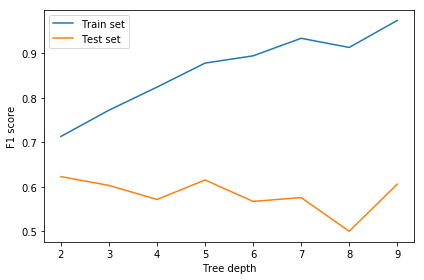

In [5]:

def sweep_depth(depth_list,score_fn, Xtrain, ytrain, Xvalid, yvalid):
    train_scores = []
    valid_scores = []
    for depth in depth_list:
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
        clf = clf.fit(Xtrain, ytrain)

        train_scores.append(score_fn(ytrain, clf.predict(Xtrain) )) 

        valid_scores.append( score_fn(yvalid, clf.predict(Xvalid) )) 
    return train_scores, valid_scores

depth_list = np.array(range(2,10))

train_scores, test_scores = sweep_depth(depth_list, get_f1, Xtrain, ytrain, Xtest, ytest)

plt.plot(depth_list,train_scores)
plt.plot(depth_list,test_scores)


plt.legend(['Train set', 'Test set'])
plt.xlabel('Tree depth')
plt.ylabel('F1 score')
plt.tight_layout()
plt.savefig('dorothea_soln/plot1.png')


0
1
2
3
4


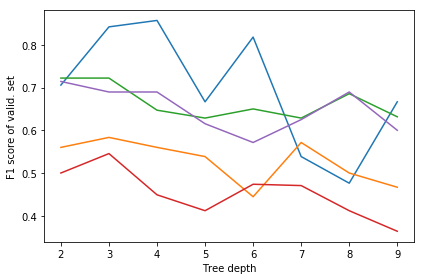

In [6]:
K = 5
n_samples = Xtrain.shape[0]
idx = np.random.permutation(n_samples)
idx = np.reshape(idx,(n_samples/K,K))

valid_scores = []
Xtraindense = Xtrain.todense()

for trial in xrange(K):
    print trial
    valid_idx = idx[:,trial]
    train_idx = np.setdiff1d(range(n_samples),valid_idx)
    Xt = ss.coo_matrix(Xtraindense[train_idx,:])
    yt = ytrain[train_idx]
    
    Xv = ss.coo_matrix(Xtraindense[valid_idx,:])
    yv = ytrain[valid_idx]
    
    xx, vs = sweep_depth(depth_list, get_f1, Xt, yt, Xv,yv)
    valid_scores.append(vs)
valid_scores = np.vstack(valid_scores).T
plt.plot(depth_list,valid_scores)

plt.xlabel('Tree depth')
plt.ylabel('F1 score of valid. set')
plt.tight_layout()
plt.savefig('dorothea_soln/plot2.png')


[[0.70588235 0.56       0.72222222 0.5        0.71428571]
 [0.84210526 0.58333333 0.72222222 0.54545455 0.68965517]
 [0.85714286 0.56       0.64705882 0.44897959 0.68965517]
 [0.66666667 0.53846154 0.62857143 0.41176471 0.61538462]
 [0.81818182 0.44444444 0.65       0.47368421 0.57142857]
 [0.53846154 0.57142857 0.62857143 0.47058824 0.625     ]
 [0.47619048 0.5        0.68571429 0.41176471 0.68965517]
 [0.66666667 0.46666667 0.63157895 0.36363636 0.6       ]]


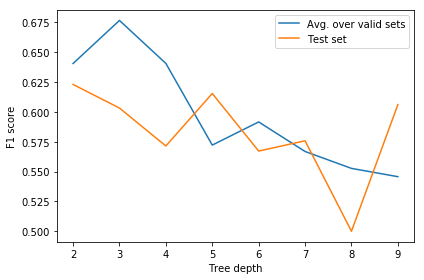

In [7]:

print valid_scores
plt.plot(depth_list,np.mean(valid_scores,axis=1))
plt.plot(depth_list,test_scores)
plt.xlabel('Tree depth')
plt.ylabel('F1 score')
plt.legend(['Avg. over valid sets', 'Test set'])
plt.tight_layout()
plt.savefig('dorothea_soln/plot3.png')